# Taller 3 · Cuantificación y error de cuantificación

**Asignatura:** Teoría de la Información y Procesado de Señal  
**Grado en Ciencia e Ingeniería de Datos (GCED) — Universidad de A Coruña**  
**Duración:** 2 horas  
**Modalidad:** Jupyter Notebook con asistencia de IA (GitHub Copilot)

---

## Objetivos de aprendizaje

Al finalizar este taller serás capaz de:

1. Implementar un **cuantificador uniforme** con redondeo y con truncado.
2. Comprender la diferencia entre **mid-rise** (redondeo) y **mid-tread** (truncado).
3. Analizar la **señal de error de cuantificación** en el dominio temporal.
4. Calcular **MSE** y **SQNR** (Signal-to-Quantization Noise Ratio).
5. Verificar experimentalmente la **regla de 6 dB/bit**.

---

## Entregables

- Notebook ejecutado completo (**Run All**) sin errores.
- Figuras correctamente etiquetadas (título, ejes, unidades).
- Secciones de **explicación** completadas con razonamiento propio.
- Respuestas a las preguntas de control.

---

## Reto central del taller

> **Cuantificar es introducir error controlado. ¿Cómo se relaciona el número de bits con la calidad de la representación?**
>
> La cuantificación es la segunda etapa de la conversión analógico-digital (ADC): después de muestrear, las amplitudes continuas se aproximan por un conjunto finito de valores. Este proceso introduce un error inevitable, pero predecible. En este taller descubrirás cómo controlarlo.

---

## Metodología de trabajo con IA

En este curso **puedes y debes usar IA**, pero siguiendo estas reglas:

| Qué puede hacer la IA | Qué debes hacer tú |
|----------------------|--------------------|
| Generar código | Entenderlo y validarlo |
| Sugerir implementaciones | Diseñar el experimento |
| Completar sintaxis | Interpretar los resultados |

### Estructura obligatoria de cada bloque

1. **Implementación**: código generado (con o sin IA).
2. **Validación**: al menos un `assert` o comprobación numérica/visual.
3. **Explicación**: 2–5 líneas en tus propias palabras explicando *qué* ocurre y *por qué*.

> **Mensaje clave:** *La IA te ayuda a escribir código, pero no a entender señales. Eso es tu trabajo.*

---

## Identificación del estudiante

Completa los siguientes campos con tu información personal:

- **Apellidos:** Juan

- **Nombre:** López Bazarra

- **Email UDC:** juan.bazarra@udc.es

---

## 0. Setup inicial

Ejecuta esta celda para importar las librerías necesarias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

print("✓ Entorno listo")

✓ Entorno listo


---

## Parte 1: Señal de partida y conceptos de cuantificación

### Contexto teórico

En el Taller 2 vimos cómo el **muestreo** convierte una señal continua en una secuencia discreta $x[n]$. Pero las amplitudes siguen siendo valores reales (precisión infinita). La **cuantificación** es el segundo paso de la conversión ADC:

$$x_a(t) \xrightarrow{\text{Muestreo}} x(n) \xrightarrow{\text{Cuantificación}} x_q(n) \xrightarrow{\text{Codificación}} \text{bits}$$

Para cuantificar una señal necesitamos:

| Parámetro | Símbolo | Significado |
|-----------|---------|-------------|
| **Número de bits** | $B$ | Determina la precisión |
| **Niveles de cuantificación** | $L = 2^B$ | Valores posibles de salida |
| **Rango dinámico** | $[x_{\min}, x_{\max}] \rightarrow R=x_{max}-x_{min}$ | Rango de la señal |
| **Paso de cuantificación** | $\Delta = \frac{x_{\max} - x_{\min}}{L}$ | Distancia entre niveles |

**Importante:** Si la señal excede el rango $[x_{\min}, x_{\max}]$, ocurre **saturación** (error grave, no controlado).

### Bloque 1 · Generación de señal acotada

**Parámetros:**
- Señal aleatoria con distribución uniforme entre [-1, 3)
- Frecuencia de muestreo: $F_s = 50$ Hz
- Duración: 100 segundos

**Tareas:**
1. Genera la señal x
2. Verifica que está dentro del rango $[-1, 3]$.
3. Represéntala con `plt.stem()`.

Text(0.5, 1.0, 'Señal aleatoria uniforme')

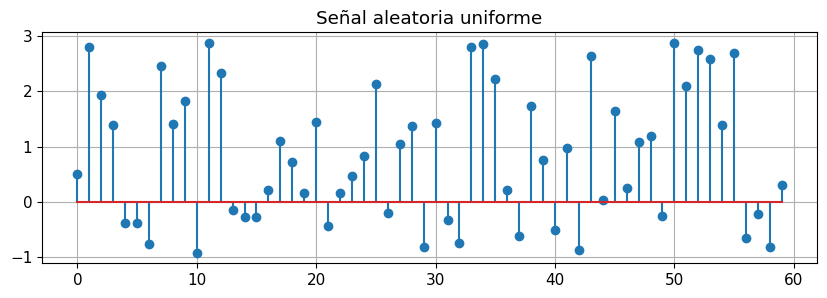

In [2]:
# === PARÁMETROS ===
# Rango considerado para cuantificadores
xmin=-1
xmax=3

# TODO: Define los parámetros de la señal: frecuencia de muestreo Fs, duración T
Fs = 50 # Frecuencia de muestreo en Hz
T = 100 # Duración de la señal en segundos


# === IMPLEMENTACIÓN ===
# TODO: Calcula N (número de muestras), genera n (índice discreto), genera x
N = int(Fs * T) # Número de muestras
n = np.arange(N) # Índice discreto
x = np.random.uniform(xmin, xmax, N) # Señal aleatoria uniforme entre xmin y xmax


# TODO: Representa la señal con stem (primeras 60 muestras)
# Representa con stem las primeras 60 muestras (sin usar use_line_collection)
plt.stem(n[:60], x[:60])
plt.title('Señal aleatoria uniforme')


In [3]:
# === VALIDACIÓN ===
assert len(x) == int(Fs * T), "La señal debe tener {int(Fs * T)} muestras"
assert np.max(x) <= xmax and np.min(x) >= xmin, "La señal debe estar en el intervalo [{xmin},{xmax}]"
#assert np.mean(x) == C, "La media de la señal debe ser igual al offset DC"

print(f"✓ N = {N} muestras, duración = {T} s")
print(f"✓ Señal generada con valores en el rango [{np.min(x):.3f}, {np.max(x):.3f}]")
print(f"  Rango dinámico: {np.max(x)-np.min(x):.3f}")
print(f"✓ Media de la señal: {np.mean(x):.3f} (debe ser ≈ {(xmax-xmin)/2+xmin:.3f})")

✓ N = 5000 muestras, duración = 100 s
✓ Señal generada con valores en el rango [-1.000, 2.999]
  Rango dinámico: 3.999
✓ Media de la señal: 0.987 (debe ser ≈ 1.000)


### Explicación (OBLIGATORIA)

**1. ¿Cuál es el valor medio de la señal?**

*Tu respuesta:* 

```
El valor medio de la señal es 1, porque se usa una distribución uniforme entre -1 y 3, y el punto medio de ese intervalo es (3 + (-1)) / 2 = 1.
``` 

**2. ¿Por qué es importante que la señal esté acotada *antes* de cuantificar?**

*Tu respuesta:*

```
Porque la cuantificación solo puede representar valores dentro de un rango específico. Si la señal excede ese rango, se produce saturación, lo que introduce un error no controlado y distorsiona la representación digital de la señal.
```

### Checkpoint del profesor (Parada 1)

Antes de continuar, verifica que tienes:
- [ ] Señal generada en el rango $[-1, 3]$
- [ ] Representación con stem correcta
- [ ] Assert pasando sin errores

---

## Parte 2: Cuantificador uniforme — redondeo vs truncado

### Contexto teórico

Hay dos formas principales de asignar un valor continuo a un nivel discreto:

**Redondeo (mid-rise):** Se asigna al nivel más cercano (punto medio del intervalo).
- Posible implementación:
  - Nivel de cuantificación: $l=\left\lfloor\frac{x - x_{\min}}{\Delta}\right\rfloor$, donde $l \in \{0, 1, ..., L-1\}$
  - Valor cuantificado $x_q = x_{\min} + l \cdot \Delta + \frac{\Delta}{2}$

**Truncado (mid-tread):** Se asigna al nivel inferior (suelo del intervalo).
- Posible implementación: 
  - Nivel de cuantificación: $l=\left\lfloor\frac{x - x_{\min}}{\Delta}\right\rfloor$, donde $l \in \{0, 1, ..., L-1\}$
  - Valor $x_q = x_{\min} + \left\lfloor\frac{x - x_{\min}}{\Delta}\right\rfloor \cdot \Delta$

### Bloque 2 · Implementación del cuantificador

---

#### Hipótesis previa

#### Hipótesis previa (COMPLETA ANTES de ejecutar)

**Pregunta:** Si cuantificas la sinusoide en el rango $[-1, 3) con $B = 4$ bits:
- La señal generada en el paso anterior, ¿está dentro de ese rango? Sí, la señal está generada entre -1 y 3, por lo que está dentro del rango especificado para la cuantificación.
- La señal cuantificada, ¿tendrá forma de "escalera"? Claro, porque al cuantificar con 4 bits, tendremos 16 niveles de cuantificación, lo que hará que la señal se aproxime a una forma de escalera.
- ¿Cuántos "peldaños" distintos esperas ver? Esperamos ver 16 peldaños distintos, ya que con 4 bits podemos representar 16 niveles de cuantificación (de 0 a 15).
- La cuantificación considera el valor máximo del rango con intervalo abierto, ¿qué ocurrirá con los valores de x iguales a 3? Ocurrirá saturación, ya que el valor 3 está fuera del rango permitido para la cuantificación. Estos valores se asignarán al nivel máximo de cuantificación, lo que introducirá un error significativo.
- **Importante**: Analiza, comprende y razona sobre la validez de las expresiones de las posibles implementaciones de redondeo y truncado presentadas más arriba. Fíjate en las diferencias. Consejo, platéate una señal sencilla (p.e. señal en [-1,1) y 2 bits) y piensa como se comportaría la implementación para diferentes amplitudes de esa señal.

---

**Tareas:**
1. Implementa `cuantificador_redondeo(x, B, xmin, xmax)` que devuelva `(x_q, Delta)`.
2. Implementa `cuantificador_truncado(x, B, xmin, xmax)` que devuelva `(x_q, Delta)`.
3. Comprobar la cuantificación de la señal anterior $x$, con $B = 4$ bits usando ambos métodos.
4. Compara visualmente la señal original con las cuantificadas (zoom de 60 muestras).

In [4]:
# === IMPLEMENTACIÓN FUNCIONES ===
def cuantificador_redondeo(x, B, xmin, xmax):
    """
    Cuantificador uniforme con REDONDEO (mid-rise).
    x_q, Delta = cuantificador_redondeo(x, B, xmin, xmax)
    
    x: valor de entrada
    B: número de bits
    xmin, xmax: rango de cuantificación
    x_q: valor cuantificado""" 

    # TODO: desarrolla el código necesario
    x_q = np.zeros_like(x) # Inicializa el array de valores cuantificados 
    Delta = (xmax - xmin) / (2**B) # Calcula el paso de cuantificación
    for i in range(len(x)):
        if x[i] < xmin:
            x_q[i] = xmin
        elif x[i] > xmax:
            x_q[i] = xmax
        else:
            x_q[i] = round((x[i] - xmin) / Delta) * Delta + xmin # Redondea al valor cuantificado más cercano

    return x_q, Delta

def cuantificador_truncado(x, B, xmin, xmax):
    """
    Cuantificador uniforme con TRUNCADO (mid-tread).
    x_q, Delta = cuantificador_redondeo(x, B, xmin, xmax)
    
    x: valor de entrada
    B: número de bits
    xmin, xmax: rango de cuantificación
    x_q: valor cuantificado""" 

    # TODO: desarrolla el código necesario 
    x_q = np.zeros_like(x) # Inicializa el array de valores cuantificados
    Delta = (xmax - xmin) / (2**B) # Calcula el paso de cuantificación
    for i in range(len(x)):
        if x[i] < xmin:
            x_q[i] = xmin
        elif x[i] > xmax:
            x_q[i] = xmax
        else:
            x_q[i] = np.floor((x[i] - xmin) / Delta) * Delta + xmin # Trunca al valor cuantificado más cercano

    
    return x_q, Delta

In [5]:
# Parámetros de cuantificación
B = 4  # bits

# Cuantifica la señal x con ambos cuantificadores
x_q_round, Delta_round = cuantificador_redondeo(x, B, xmin, xmax)
x_q_trunc, Delta_trunc = cuantificador_truncado(x, B, xmin, xmax)


In [6]:
# === VALIDACIÓN ===
assert x_q_round is not None, "Implementa el cuantificador con redondeo (mid-rise)"
assert x_q_trunc is not None, "Implementa el cuantificador con truncado (mid-tread)"
assert Delta_round == Delta_trunc, "Los cuantificadores deben tener el mismo Δ"
assert len(x_q_round) == N, "La señal cuantificada debe tener N muestras"

# Verificar que los niveles son realmente discretos (solo L valores posibles)
niveles_round = len(np.unique(np.round(x_q_round, 6)))
print(f"✓ Cuantificadores implementados")
print("")
print(f"  B = {B} bits → L = {2**B} niveles")
print(f"  Rango dinámico: {xmax-xmin:.3f} → Δ = {(xmax-xmin)/2**B:.3f}")
print(f"  Deltas de los cuantificadores de redondeo y truncado iguales.")
print(f"  Δ = Δ_round = Δ_trunc = {Delta_round:.4f}")
print(f"  Valores de cuantificación dentro de los esperados.")


✓ Cuantificadores implementados

  B = 4 bits → L = 16 niveles
  Rango dinámico: 4.000 → Δ = 0.250
  Deltas de los cuantificadores de redondeo y truncado iguales.
  Δ = Δ_round = Δ_trunc = 0.2500
  Valores de cuantificación dentro de los esperados.


### Bloque 2b · Comparación visual

Representa en una gráfica, con 2 figuras, lo siguiente:
- Izquierda: 60 muestras de la señal original $x$ con plot normal, superpuesta con la señal cuantificada por redondeo $x_{q,red}$ con plot con la opción `drawstyle="steps-post"`.
- Derecha: 60 muestras de la señal original $x$ con plot normal, superpuesta con la señal cuantificada por truncado $x_{q,trunc}$ con plot con la opción `drawstyle="steps-post"`.

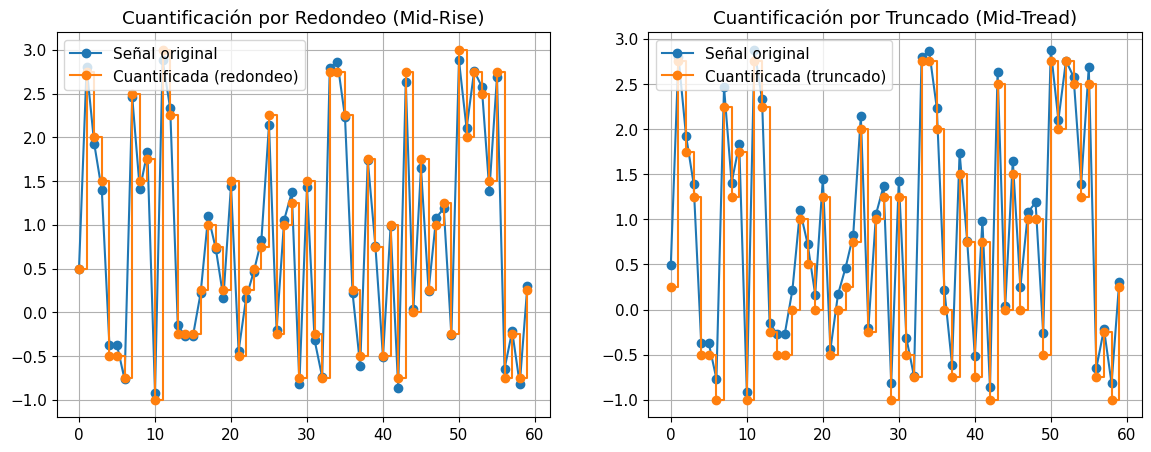

In [7]:
# === Visualización ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TODO: Izquierda: 60 muestras de la señal original x (plot) + señal cuantificada por redondeo (plot con drawstyle="steps-post")
axes[0].plot(n[:60], x[:60], label='Señal original', marker='o')
axes[0].plot(n[:60], x_q_round[:60], label='Cuantificada (redondeo)', drawstyle='steps-post', marker='o')
axes[0].set_title('Cuantificación por Redondeo (Mid-Rise)')
axes[0].legend()


# TODO: Derecha: 60 muestras de la señal original x (plot) + señal cuantificada por truncado (plot con drawstyle="steps-post")
axes[1].plot(n[:60], x[:60], label='Señal original', marker='o')
axes[1].plot(n[:60], x_q_trunc[:60], label='Cuantificada (truncado)', drawstyle='steps-post', marker='o')
axes[1].set_title('Cuantificación por Truncado (Mid-Tread)')
axes[1].legend()    

### Explicación (OBLIGATORIA)

**1. ¿Observas una gran diferencia entre ambos cuantificadores?**

*Tu respuesta:*

```
La verdad es que no se observa una gran diferencia entre ambos cuantificadores en general, ya que ambos métodos asignan valores discretos a la señal original. Sin embargo, el redondeo tiende a asignar valores más cercanos a la señal original, mientras que el truncado siempre asigna al nivel inferior, lo que puede introducir un error mayor en algunos casos. En la gráfica, esto se puede observar como pequeñas diferencias en los niveles de cuantificación entre ambos métodos.
```

**2. ¿Los escalones son realmente la señal cuantificada?**

*Tu respuesta:*

```
Sí, los escalones representan la señal cuantificada. Cada escalón corresponde a un nivel de cuantificación específico, y la altura del escalón indica el valor cuantificado asignado a esa muestra de la señal original. La forma de escalera se debe a que la señal original se aproxima a valores discretos, lo que resulta en una representación en forma de peldaños.
```

### Checkpoint del profesor (Parada 2)

Antes de continuar, verifica:
- [ ] Ambos cuantificadores implementados y funcionando
- [ ] Gráficas mostrando la cuantificación vs la señal original (redondeo) vs sesgado (truncado)
- [ ] Asserts pasando sin errores

---

## Parte 3: Error de cuantificación — propiedades y límites

### Contexto teórico

El **error de cuantificación** es:
$$e_q(n) = x_q(n) - x(n)$$

Bajo ciertas condiciones (señal "suficientemente larga y variada"), el error se comporta como **ruido blanco uniforme**

**Redondeo (mid-rise):** Se asigna al nivel más cercano (punto medio del intervalo).
- Error con distribución uniforme simétrico: $-\frac{\Delta}{2} < e_q(n) \leq \frac{\Delta}{2}$
- Media del error $\approx 0$ (sin sesgo)
- Varianza = $\sigma_e^2 = \frac{\Delta^2}{12}$
- Error cuadrático medio MSE $\approx \sigma_e^2$ (debido a que la media es 0)


**Truncado (mid-tread):** Se asigna al nivel inferior (suelo del intervalo).
- Error con distribución uniforme asimétrico: $-\Delta < e_q(n) \leq 0$
- Media del error $\approx -\frac{\Delta}{2}$ (con sesgo)
- Varianza = $\sigma_e^2 = \frac{\Delta^2}{12}$
- Error cuadrático medio MSE $\approx \sigma_e^2 + \bar{e}^2 = \frac{\Delta^2}{3}$ (debido al sesgo)


| Método | Error | Media | Varianza | MSE |
|--------|-------|-------|----------|-----|
| **Redondeo** | $(-\Delta/2, \Delta/2]$ | 0 | $\Delta^2/12$ |  $\Delta^2/12$ |
| **Truncado** | $(-\Delta, 0]$ | $-\Delta/2$ | $\Delta^2/12$ |  $\Delta^2/3$ |

donde
- Varianza $\sigma_e^2 = \text{var}(e) = \frac{1}{N}\sum_{i=0}^{N-1}(e_i - \bar{e})^2$
- $\text{MSE} = \frac{1}{N}\sum_{i=0}^{N-1} e_i^2 = \sigma_e^2 + \bar{e}^2$

### Bloque 3a · Análisis del error de cuantificación

---

#### Hipótesis previa

**Pregunta:** Para el error de cuantificación anterior, ¿qué esperas encontrar?:
- Varianza teórica: $\sigma_e^2 = \Delta^2/12 = $ 
- MSE teórico: ____ (redondeo) y ____ (truncado)
- El error, ¿debería tener media positiva, negativa o nula? 
- ¿Esperas que el histograma de los errores sea plano o de otra forma? (razona sobre lo que representa el histograma de una señal) ____

---
Partiendo de los errores analizados antes, calcula las siguientes métricas:
**Tareas:**
1. Muestra la media y varianza empíricas del error.
2. Compara con los valores teóricos.
3. Representa: (a) el error en el tiempo, (b) el histograma del error.

In [8]:
# === IMPLEMENTACIÓN ===

# TODO: calcula los vectores de error de cuantificación para ambos métodos, e_round y e_trunc, como la diferencia entre la señal cuantificada y la señal original x
# Calcula y muestra los valores mínimos, máximos y medios de estos errores, min_e_round, max_e_round, mean_e_round, min_e_trunc, max_e_trunc y mean_e_trunc.
# Calcula la varianza de estos errores, variance_round y variance_trunc. (puedes usar la función de numpy correspondiente)
# Cacula el MSE de estos errores, mse_round y mse_trunc.
e_round = x_q_round - x # Error de cuantificación para redondeo
e_trunc = x_q_trunc - x # Error de cuantificación para truncado
min_e_round = np.min(e_round)
max_e_round = np.max(e_round)
mean_e_round = np.mean(e_round)
min_e_trunc = np.min(e_trunc)
max_e_trunc = np.max(e_trunc)
mean_e_trunc = np.mean(e_trunc)
variance_round = np.var(e_round)
variance_trunc = np.var(e_trunc)
mse_round = np.mean(e_round**2)
mse_trunc = np.mean(e_trunc**2)
print(f"✓ Errores de cuantificación calculados")
print("")
print(f"  Redondeo (Mid-Rise):")
print(f"    Error mínimo: {min_e_round:.4f}")
print(f"    Error máximo: {max_e_round:.4f}")
print(f"    Error medio: {mean_e_round:.4f}")
print(f"    Varianza del error: {variance_round:.6f}")
print(f"    MSE del error: {mse_round:.6f}")
print(f"  Truncado (Mid-Tread):")
print(f"    Error mínimo: {min_e_trunc:.4f}")
print(f"    Error máximo: {max_e_trunc:.4f}")
print(f"    Error medio: {mean_e_trunc:.4f}")
print(f"    Varianza del error: {variance_trunc:.6f}")
print(f"    MSE del error: {mse_trunc:.6f}")    



✓ Errores de cuantificación calculados

  Redondeo (Mid-Rise):
    Error mínimo: -0.1250
    Error máximo: 0.1250
    Error medio: 0.0007
    Varianza del error: 0.005116
    MSE del error: 0.005117
  Truncado (Mid-Tread):
    Error mínimo: -0.2499
    Error máximo: -0.0000
    Error medio: -0.1255
    Varianza del error: 0.005266
    MSE del error: 0.021023


In [9]:
# === VALIDACIÓN ===
assert abs(mean_e_round) < 0.02, f"La media del error de cuantificación por redondeo debería ser ≈ 0, es {mean_e_round:.4f}"
assert abs(mean_e_trunc + Delta_trunc/2) < 0.02, f"La media del error de cuantificación por truncado debería ser ≈ -Δ/2 = {-Delta_trunc/2:.4f}, es {mean_e_trunc:.4f}"
assert abs(mse_round) / Delta_round**2/12 < 0.3, f"El MSE empírico para el cuantificador de redondeo debería estar alrededor de Δ²/12 ({Delta_round**2/12:.6f})"
assert abs(mse_trunc - (variance_trunc + mean_e_trunc**2)) / Delta_trunc**2/4 < 0.3, f"El MSE empírico para el cuantificador de truncado debería estar alrededor de Δ²/3 = ({Delta_round**2/4:.6f})"

print("✓ Errores de cuantificación analizado correctamente")
print("")
print(f"✓ Cuantificador por redondeo (mid-rise)")
print(f"  Error mínimo: {min_e_round:.5f}, error máximo: {max_e_round:.5f} (entre (-Δ/2, Δ/2] = ({-Delta_round/2:.5f}, {Delta_round/2:.5f}])")
print(f"  Media error redondeo: {mean_e_round:.5f} (≈ 0)")
print(f"  Varianza error redondeo: {variance_round:.5f} (≈ Δ^2/12 = {Delta_round**2/12:.5f})")
print(f"  MSE error redondeo: {mse_round:.5f} (≈ varianza para error con media ≈ 0)")
print("")
print(f"✓ Cuantificador por truncado (mid-tread)")
print(f"  Error mínimo: {min_e_trunc:.5f}, error máximo: {max_e_trunc:.5f} (entre (-Δ, 0] = ({-Delta_trunc:.5f}, 0])")
print(f"  Media error truncado: {mean_e_trunc:.5f} (≈ -Δ/2 = {-Delta_trunc/2:.5f})")
print(f"  Varianza error truncado: {variance_trunc:.5f} (≈ Δ^2/12 = {Delta_trunc**2/12:.5f})")
print(f"  MSE error truncado: {mse_trunc:.5f} (≈ Δ^2/3 = {Delta_trunc**2/3:.5f})")
     

✓ Errores de cuantificación analizado correctamente

✓ Cuantificador por redondeo (mid-rise)
  Error mínimo: -0.12496, error máximo: 0.12498 (entre (-Δ/2, Δ/2] = (-0.12500, 0.12500])
  Media error redondeo: 0.00067 (≈ 0)
  Varianza error redondeo: 0.00512 (≈ Δ^2/12 = 0.00521)
  MSE error redondeo: 0.00512 (≈ varianza para error con media ≈ 0)

✓ Cuantificador por truncado (mid-tread)
  Error mínimo: -0.24991, error máximo: -0.00005 (entre (-Δ, 0] = (-0.25000, 0])
  Media error truncado: -0.12553 (≈ -Δ/2 = -0.12500)
  Varianza error truncado: 0.00527 (≈ Δ^2/12 = 0.00521)
  MSE error truncado: 0.02102 (≈ Δ^2/3 = 0.02083)


### Bloque 3b · Comprobación visual
Representa en una gráfica, con 4 figuras con lo siguiente:
- Arriba a la izquierda: error de cuantificación de redondeo, e_round, con stem, con líneas horizontales mostrando los valores máximo, mínimo y media esperados.
- Arriba a la derecha: error de cuantificación de truncado, e_trunc, son stem, con líneas horizontales mostrando los valores máximo, mínimo y media esperados.
- Abajo a la izquierda: histograma del error por redondeo, e_round, con `plt.hist()`
- Abajo a la derecha: histograma del error de truncado, e_trunc, con `plt.hist()`

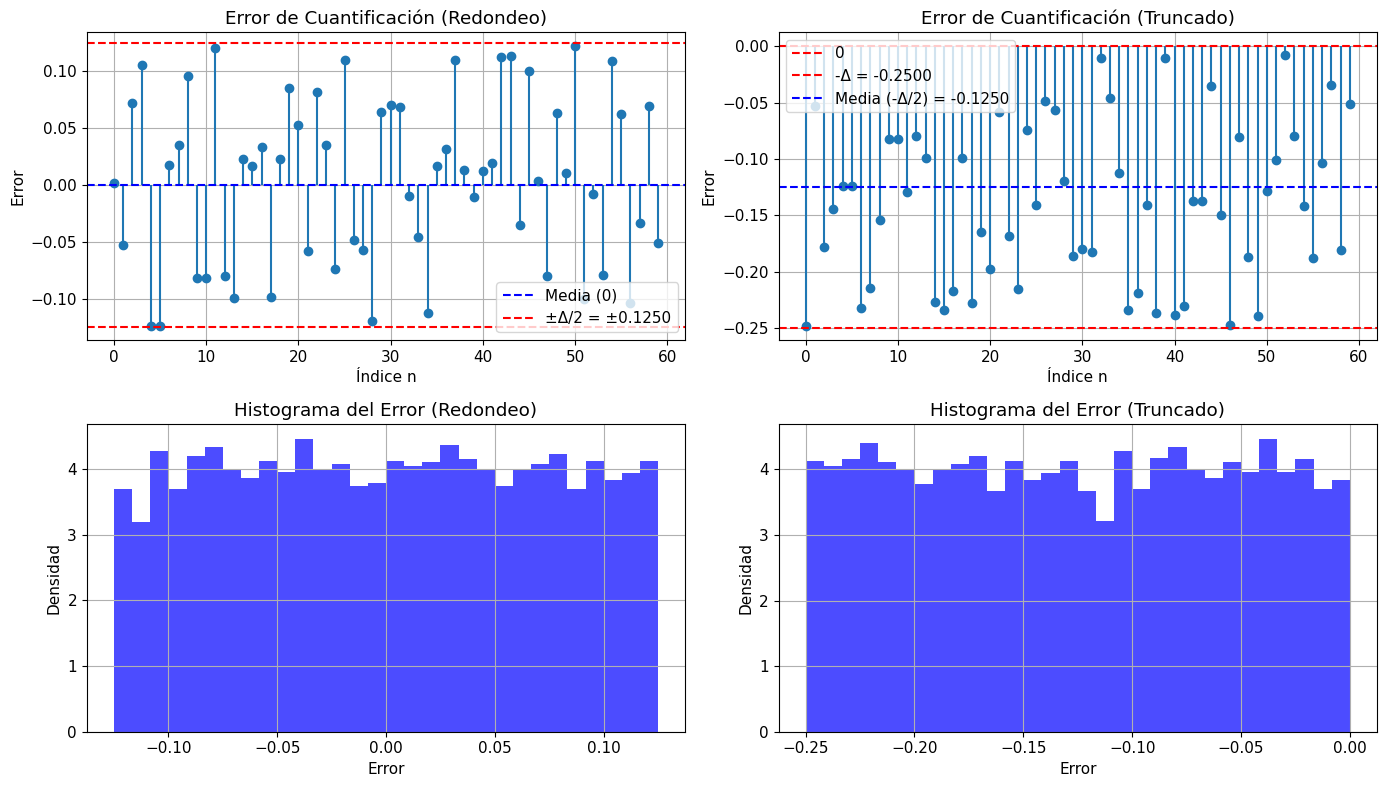

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Arriba a la izquierda: Error redondeo (stem), con líneas horizontales indicando media, mínimo y máximo del error
ax = axes[0, 0]
ax.stem(n[:60], e_round[:60], basefmt=" ")
ax.axhline(y=0, color='blue', linestyle='--', linewidth=1.5, label='Media (0)')
ax.axhline(y=Delta_round/2, color='red', linestyle='--', label=f'±Δ/2 = ±{Delta_round/2:.4f}')
ax.axhline(y=-Delta_round/2, color='red', linestyle='--')
ax.set_title("Error de Cuantificación (Redondeo)")
ax.set_xlabel("Índice n")
ax.set_ylabel("Error")
ax.legend()
ax.grid(True)

# Arriba a la derecha: Error truncado (stem), con líneas horizontales indicando media, mínimo y máximo del error
ax = axes[0, 1]
ax.stem(n[:60], e_trunc[:60], basefmt=" ")
ax.axhline(y=0, color='red', linestyle='--', label='0')
ax.axhline(y=-Delta_trunc, color='red', linestyle='--', label=f'-Δ = -{Delta_trunc:.4f}')
ax.axhline(y=-Delta_trunc/2, color='blue', linestyle='--', linewidth=1.5,
           label=f'Media (-Δ/2) = {-Delta_trunc/2:.4f}')
ax.set_title("Error de Cuantificación (Truncado)")
ax.set_xlabel("Índice n")
ax.set_ylabel("Error")
ax.legend()
ax.grid(True)

# Abajo a la izquierda: Histograma del error por redondeo
ax = axes[1, 0]
ax.hist(e_round, bins=30, density=True, alpha=0.7, color='blue')
ax.set_title("Histograma del Error (Redondeo)")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad")
ax.grid(True)

# Abajo a la derecha: Histograma del error por truncado
ax = axes[1, 1]
ax.hist(e_trunc, bins=30, density=True, alpha=0.7, color='blue')
ax.set_title("Histograma del Error (Truncado)")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad")
ax.grid(True)

plt.tight_layout()
plt.show()

### Explicación (OBLIGATORIA)

**1. ¿Por qué el error tiene media aproximadamente nula (con redondeo)?**

*Tu respuesta:*

```
Porque el redondeo asigna valores al nivel más cercano, lo que hace que los errores positivos y negativos se compensen entre sí. Esto resulta en una media del error cercana a cero, ya que no hay un sesgo sistemático hacia valores más altos o más bajos, a diferencia del truncado que siempre asigna al nivel inferior, lo que introduce un sesgo negativo.
```

**2. ¿Cuál es la relación entre el paso $\Delta$ y la varianza del error? ¿Qué implica para la calidad?**

*Tu respuesta:*

```
La varianza del error de cuantificación es proporcional al cuadrado del paso $\Delta$, específicamente $\sigma_e^2 = \frac{\Delta^2}{12}$ para el redondeo. Esto implica que a medida que el paso de cuantificación $\Delta$ disminuye (lo que ocurre al aumentar el número de bits), la varianza del error también disminuye, lo que mejora la calidad de la representación digital de la señal. En otras palabras, una mayor precisión (menor $\Delta$) conduce a un error de cuantificación más pequeño y, por lo tanto, a una mejor calidad de la señal cuantificada.
```

**3. ¿Qué representa el histograma normalizado de una secuencia desde el punto de vista de probabilidades? ¿Por qué los histogramas del error tienen esa forma característica?**

*Tu respuesta:*

```
El histograma normalizado de una secuencia representa la distribución de probabilidad de los valores en esa secuencia. En el caso del error de cuantificación, los histogramas tienen una forma característica porque el error se distribuye uniformemente dentro de un rango específico (por ejemplo, entre -$\Delta/2$ y $\Delta/2$ para el redondeo). Esto se debe a que cada valor de la señal original tiene la misma probabilidad de ser cuantificado a cualquier nivel dentro de ese rango, lo que resulta en una distribución uniforme del error.
```

### Bloque 3c Saturación de la cuantificación
Coge un valor por encima o otro por debajo del rango considerado para la señal. Calcula el valor de cuantificación y el error cometido para cada caso. ¿Qué ocurre? ¿Cómo se relaciona con el concepto de saturación?

In [11]:
# TODO: Genera la cuantificación de dos valores fuera del rango [xmin, xmax], por ejemplo x_out = [xmin-2*Delta, xmax+2*Delta], y cuantifícalos con ambos métodos.
# Calcula el vector de errores de cuantificación, e_out, para estos valores fuera de rango, y analiza qué sucede.
x_out = np.array([xmin - 2*Delta_round, xmax + 2*Delta_round]) # Valores fuera del rango
x_out_q_round, _ = cuantificador_redondeo(x_out, B, xmin, xmax) # Cuantificación por redondeo
x_out_q_trunc, _ = cuantificador_truncado(x_out, B, xmin, xmax) # Cuantificación por truncado
e_out_round = x_out_q_round - x_out # Error de cuantificación por redondeo
e_out_trunc = x_out_q_trunc - x_out # Error de cuantificación
print(f"✓ Cuantificación de valores fuera del rango [{xmin}, {xmax}]")
print("")
print(f"  Valores fuera de rango: {x_out}")
print(f"  Cuantificación por redondeo: {x_out_q_round}, errores: {e_out_round}")
print(f"  Cuantificación por truncado: {x_out_q_trunc}, errores: {e_out_trunc}")
print("")   
print(f"✓ Análisis de errores para valores fuera de rango:")
print(f"  Redondeo: ambos valores se cuantifican al límite más cercano dentro del rango, con errores de cuantificación de {e_out_round}")
print(f"  Truncado: ambos valores se cuantifican al límite más cercano dentro del rango, con errores de cuantificación de {e_out_trunc}")

                        


✓ Cuantificación de valores fuera del rango [-1, 3]

  Valores fuera de rango: [-1.5  3.5]
  Cuantificación por redondeo: [-1.  3.], errores: [ 0.5 -0.5]
  Cuantificación por truncado: [-1.  3.], errores: [ 0.5 -0.5]

✓ Análisis de errores para valores fuera de rango:
  Redondeo: ambos valores se cuantifican al límite más cercano dentro del rango, con errores de cuantificación de [ 0.5 -0.5]
  Truncado: ambos valores se cuantifican al límite más cercano dentro del rango, con errores de cuantificación de [ 0.5 -0.5]


In [12]:
assert np.max(np.abs(e_out_round)) > Delta_round/2 and np.max(np.abs(e_out_trunc)) > Delta_trunc, "Los errores de cuantificación para valores fuera del rango deberían estar limitados por Δ/2 para redondeo y Δ para truncado"
print("✓ Cuantificación de valores fuera del rango")
print(f"  Valores fuera de rango: {x_out}")
print(f"  Cuantificación por redondeo: {x_out_q_round}, errores: {e_out_round}. Debería ser <= Δ/2 = {Delta_round/2:.4f}")
print(f"  Cuantificación por truncado: {x_out_q_trunc}, errores: {e_out_trunc}. Debería ser <= Δ = {Delta_trunc:.4f}")

✓ Cuantificación de valores fuera del rango
  Valores fuera de rango: [-1.5  3.5]
  Cuantificación por redondeo: [-1.  3.], errores: [ 0.5 -0.5]. Debería ser <= Δ/2 = 0.1250
  Cuantificación por truncado: [-1.  3.], errores: [ 0.5 -0.5]. Debería ser <= Δ = 0.2500


### Explicación (OBLIGATORIA)

**1. ¿Qué le pasa al error cuando hay saturación? ¿Por qué excede $\pm\Delta/2$?**

*Tu respuesta:*

```
Cuando ocurre saturación, el error excede $\pm\Delta/2$ porque la señal original está fuera del rango $[x_{\min}, x_{\max}]$. El cuantificador asigna entonces al nivel límite (máximo o mínimo), introduciendo un error no controlado igual a la diferencia entre el valor real y el nivel saturado. Por ejemplo, si $x = x_{\max} + 0.5$ y el cuantificador asigna $x_{\max}$, el error será $-0.5$, mucho mayor que $\Delta/2$.
```

**2. ¿Cómo se puede evitar la saturación en la práctica?**

*Tu respuesta:*
```
Se puede evitar la saturación en la práctica mediante técnicas como:
- **Ajuste del rango dinámico**: Asegurarse de que el rango de cuantificación se adapte a la señal, por ejemplo, utilizando un amplificador para escalar la señal antes de cuantificar.
- **Clipping controlado**: Implementar un sistema que limite la señal a un rango específico antes de cuantificar, aunque esto puede introducir distorsión.
- **Uso de cuantificadores no uniformes**: En algunos casos, como en señales con una amplia gama dinámica, se pueden usar cuantificadores no uniformes (p.e. cuantificación logarítmica) para manejar mejor los valores extremos sin saturación.
```

### Checkpoint del profesor (Parada 3)

Antes de continuar, verifica:
- [ ] Error de cuantificación calculado con estadísticas (media, varianza, error cuadrático medio)
- [ ] Gráficas del error en el tiempo con líneas de referencia
- [ ] Histogramas del error mostrando la distribución
- [ ] Análisis de saturación realizado
- [ ] Comparación con valores teóricos

## Parte 4: Cuantificación no uniforme

### Curvas de transferencia: cuantificación uniforme vs ley μ

Para visualizar la diferencia entre cuantificación **uniforme** y **no uniforme (ley μ)**, representamos la curva de transferencia de ambos cuantificadores con redondeo sobre una señal lineal en $[-1, 1]$.

Un cuantificador no uniforme, como la **ley μ**, aplica una compresión logarítmica antes de cuantificar. La **ley μ** aplica esta compresión logarítmica:

$$F(x) = \text{sgn}(x) \frac{\ln(1 + \mu|x|)}{\ln(1 + \mu)}$$

y para cuantificar uniformemente la señal comprimida, se expande con la función inversa. El resultado es un cuantificador que dedica **más niveles a las amplitudes pequeñas** (frecuentes en voz) y menos a las grandes.

## Bloque 4a · Implementación de la ley μ y curvas de transferencia 

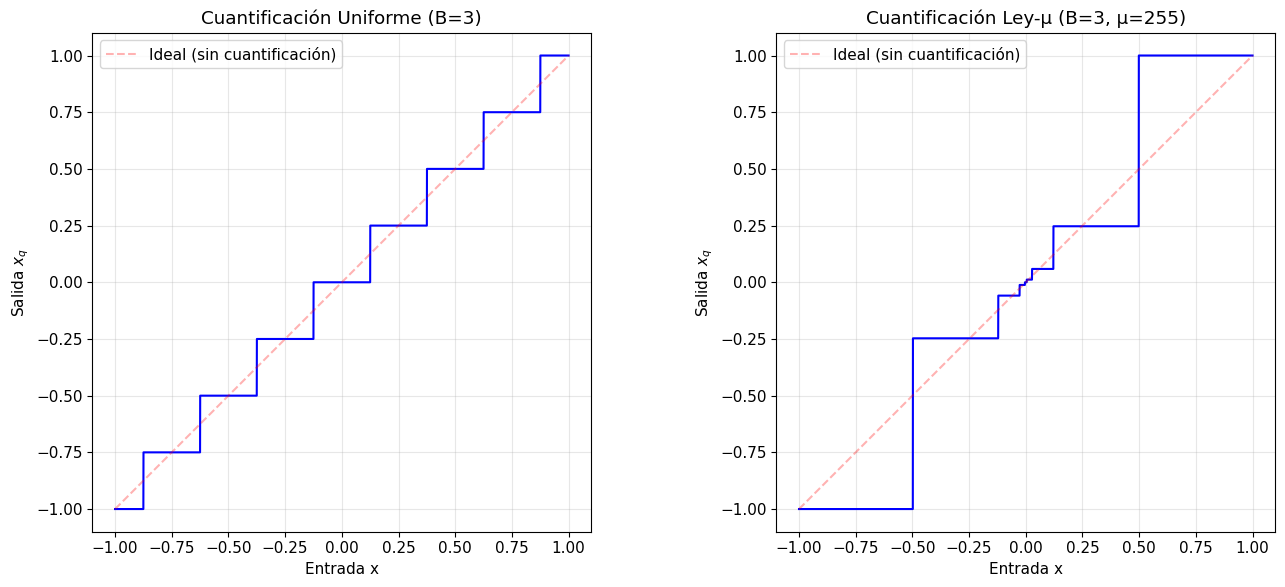

In [13]:
# === CURVAS DE TRANSFERENCIA ===

def mu_law_compress(x, mu=255):
    """Compresión ley-μ: entrada y salida en [-1, 1]"""
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

def mu_law_expand(y, mu=255):
    """Expansión ley-μ: inversa de la compresión"""
    return np.sign(y) * ((1 + mu)**np.abs(y) - 1) / mu

# Señal lineal de prueba
x_lin = np.linspace(-1, 1, 10000)
B_demo = 3
mu = 255

# Cuantificación uniforme por redondeo
x_q_uniform, _ = cuantificador_redondeo(x_lin, B_demo, -1, 1)

# Cuantificación ley-μ: comprimir → cuantificar uniforme → expandir
x_compressed = mu_law_compress(x_lin, mu)
x_compressed_q, _ = cuantificador_redondeo(x_compressed, B_demo, -1, 1)
x_q_mulaw = mu_law_expand(x_compressed_q, mu)

# Gráfica comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, x_q, titulo in zip(axes,
                            [x_q_uniform, x_q_mulaw],
                            [f'Uniforme (B={B_demo})',
                             f'Ley-μ (B={B_demo}, μ={mu})']):
    ax.plot(x_lin, x_q, 'b-', linewidth=1.5)
    ax.plot([-1, 1], [-1, 1], 'r--', alpha=0.3, label='Ideal (sin cuantificación)')
    ax.set_xlabel('Entrada x')
    ax.set_ylabel('Salida $x_q$')
    ax.set_title(f'Cuantificación {titulo}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## Bloque 4b · Efecto de la cuantificación no uniforme en una señal con amplitudes pequeñas y grandes

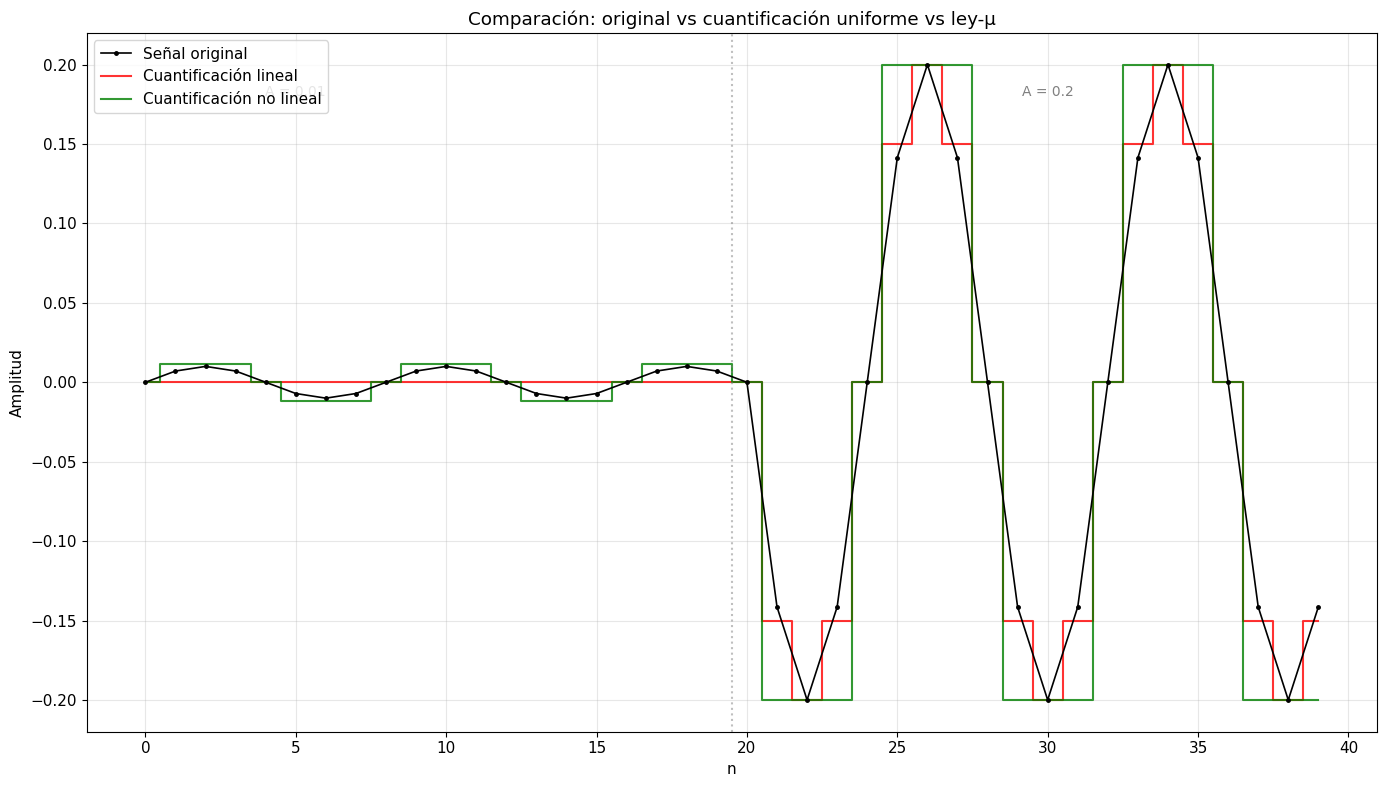

In [14]:
# === EFECTO EN SEÑAL CON DOS NIVELES DE AMPLITUD ===

N_demo = 40
n_demo = np.arange(N_demo)

# Señal con parte de amplitud baja (A=0.01) y parte de amplitud alta (A=0.2)
xe = np.append([0.01 * np.sin(2*np.pi*1000/8000 * n_demo[0:int(N_demo/2)])],
               [0.2  * np.sin(2*np.pi*1000/8000 * n_demo[int(N_demo/2):N_demo])])

# Rango real de la señal
xmin_e, xmax_e = np.min(xe), np.max(xe)

# Cuantificación uniforme con rango real
x_q_unif, _ = cuantificador_redondeo(xe, B_demo, xmin_e, xmax_e)

# Cuantificación ley-μ: normalizar a [-1,1] → comprimir → cuantificar → expandir → desnormalizar
xe_norm = 2 * (xe - xmin_e) / (xmax_e - xmin_e) - 1
x_comp_q, _ = cuantificador_redondeo(mu_law_compress(xe_norm, mu), B_demo, -1, 1)
x_q_mu = (mu_law_expand(x_comp_q, mu) + 1) / 2 * (xmax_e - xmin_e) + xmin_e

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(n_demo, xe, 'k.-', linewidth=1.2, markersize=5, label='Señal original', zorder=3)
ax.step(n_demo, x_q_unif, 'r-', linewidth=1.5, where='mid', label='Cuantificación lineal', alpha=0.8)
ax.step(n_demo, x_q_mu, 'g-', linewidth=1.5, where='mid', label='Cuantificación no lineal', alpha=0.8)

ax.axvline(x=19.5, color='gray', linestyle=':', alpha=0.5)
ax.text(5, 0.18, 'A = 0.01', ha='center', fontsize=10, color='gray')
ax.text(30, 0.18, 'A = 0.2', ha='center', fontsize=10, color='gray')
ax.set_xlabel('n')
ax.set_ylabel('Amplitud')
ax.set_title('Comparación: original vs cuantificación uniforme vs ley-μ')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Explicación (OBLIGATORIA)

**1. Explica las curvas de transferencia y las diferencias que observas**

*Tu respuesta:*

```
Las curvas de transferencia muestran cómo se asignan los valores de entrada a los niveles de cuantificación. En la curva de cuantificación uniforme, la relación es lineal, lo que significa que cada nivel de cuantificación representa un intervalo igual en la señal original. En contraste, la curva de la ley μ muestra una compresión logarítmica, donde las amplitudes pequeñas se asignan a niveles de cuantificación más cercanos entre sí, mientras que las amplitudes grandes se asignan a niveles más separados. Esto permite que la ley μ capture mejor las variaciones en señales con amplitudes pequeñas, como la voz humana, mientras que la cuantificación uniforme puede perder detalles en esas regiones.
```

**2. Relaciona las curvas de transferencia con lo que ves en la cuantificación de la señal de prueba de dos niveles de amplitud**

*Tu respuesta:*

```
En la cuantificación de la señal de prueba, la curva de transferencia de la ley μ muestra que las amplitudes pequeñas se cuantifican con mayor precisión, lo que se refleja en una representación más detallada de esas partes de la señal. En cambio, la cuantificación uniforme asigna niveles de cuantificación de manera equidistante, lo que puede resultar en una pérdida de detalle para las amplitudes pequeñas y una representación menos precisa en esas regiones. Esto se puede observar en la gráfica, donde la señal cuantificada con la ley μ conserva mejor las características de las amplitudes pequeñas en comparación con la cuantificación uniforme.
```

---

## Parte 5: SQNR y la regla de los 6 dB/bit

### Contexto teórico

La **SQNR** (Signal-to-Quantization Noise Ratio) mide la calidad de la cuantificación y sigue esta expresión:

$$\boxed{\text{SQNR} = 10 \log_{10}\left(\frac{P_x}{P_e}\right) \text{ dB}}$$

donde $P_x$ es la potencia de la señal original y $P_e$ es la potencia del error de cuantificación (MSE).

**Expresión teórica para cuantificador uniforme por redondeo (mid-rise)**

En un cuantificador uniforme con redondeo aparece la regla de los ~ 6 dB/bit de la expresión vista en clase:
- Cuantificador con redondeo: $P_e = MSE = \Delta^2/12$
- Cuantificador uniforme $\Delta = R/2^B$ y $R = x_{\max} - x_{\min}$ es el rango dinámico de la señal, por lo que $P_e = \frac{R^2}{12 \cdot 4^B}$.

$$\text{SQNR} = 10 \log_{10}(P_x) + 6.02 \cdot B + 10 \log_{10}(12) - 20 \log_{10}(R)$$

En el caso de señales acotadas en $[-1, 1]$, $R = 2$, nos sale la expresión vista en clase de teoría:

$$\text{SQNR}_{R=2} = 10 \log_{10}(P_x) - 10 \log_{10}(P_e)= 10 \log_{10}(P_x) + 6.02 \cdot B +  4.76 \text{ dB}$$

### Bloque 5a · Verificación experimental de la regla 6 dB/bit para un cuantificador uniforme con redondeo

---

#### Hipótesis previa

**Pregunta:** Si con $B = 4$ bits obtienes un cierto SQNR, ¿cuánto esperas que mejore al pasar a $B = 5$ bits?

- Mejora esperada: ____ dB

---

**Tareas:**
1. Calcula MSE y SQNR para $B = 2, 3, 4, 5, 6, 7, 8$ bits.
2. Grafica SQNR empírica vs $B$, junto con la expresión teórica.
3. Analiza la pendiente empírica y compara con el valor de 6.02 dB/bit.

**Nota:**
Para calcular empíricamente la potencia de la señal puedes usar $P_x = \frac{1}{N}\sum_{n=0}^{N-1} x[n]^2$, y para la potencia del error puedes usar $P_e = \frac{1}{N}\sum_{n=0}^{N-1} e_{round}[n]^2$.

In [17]:
# === IMPLEMENTACIÓN ===
bits_list = [2, 3, 4, 5, 6, 7, 8]
mse_list = []
sqnr_list = []
sqnr_teorico_list = []

# Potencia de la señal original
P_x = np.mean(x**2)

for B_i in bits_list:
    # Cuantifica con B_i bits (redondeo)
    x_q_i, Delta_i = cuantificador_redondeo(x, B_i, xmin, xmax)
    
    # MSE empírico
    mse_i = np.mean((x_q_i - x)**2)
    mse_list.append(mse_i)

    # SQNR empírico (dB)
    sqnr_i = 10 * np.log10(P_x / mse_i)
    sqnr_list.append(sqnr_i)

    # SQNR teórico usando Δ del cuantificador: P_e = Δ^2 / 12
    P_e_teorico = Delta_i**2 / 12
    sqnr_teorico_i = 10 * np.log10(P_x / P_e_teorico)
    sqnr_teorico_list.append(sqnr_teorico_i)


  B          MSE    SQNR (dB)   Teórico (dB)   Diferencia
------------------------------------------------------------
  2     0.084835        14.36          14.44        -0.08
  3     0.020963        20.43          20.46        -0.03
  4     0.005117        26.56          26.48        +0.08
  5     0.001313        32.47          32.50        -0.04
  6     0.000330        38.47          38.52        -0.06
  7     0.000081        44.57          44.54        +0.02
  8     0.000020        50.62          50.56        +0.06
Observa el incremento de la SQNR con cada incremento del número de bits


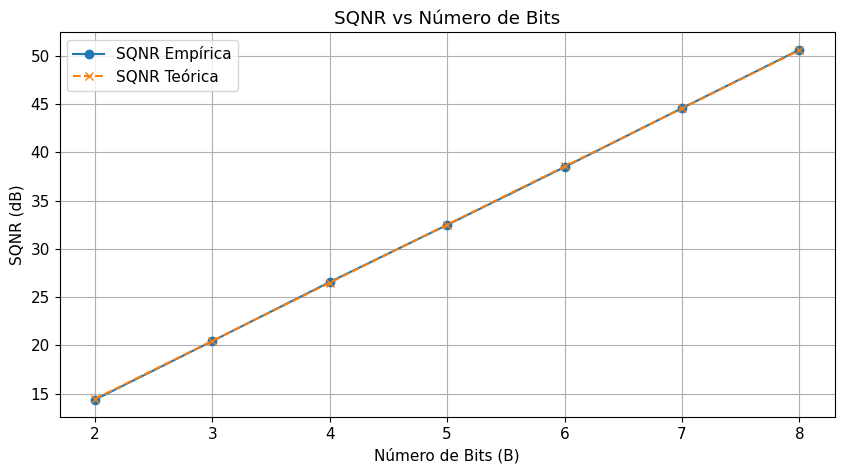

In [18]:
#=== VALIDACIÓN ===
assert len(mse_list) == len(bits_list), "mse_list debe tener el mismo número de elementos que bits_list"
assert len(sqnr_list) == len(bits_list), "sqnr_list debe tener el mismo número de elementos que bits_list"
assert len(sqnr_teorico_list) == len(bits_list), "sqnr_teorico_list debe tener el mismo número de elementos que bits_list"
assert all(mse > 0 for mse in mse_list), "Todos los valores de MSE deben ser positivos"
assert np.allclose(sqnr_teorico_list, sqnr_list, rtol=0.05, atol=0.5), "sqnr_teorico_list debe ser similar a sqnr_list"
# Verificar que SQNR crece monotónicamente con B
for i in range(1, len(sqnr_list)):
    assert sqnr_list[i] > sqnr_list[i-1], f"SQNR debe crecer con B"
    
# Tabla de resultados
print(f"{'B':>3} {'MSE':>12} {'SQNR (dB)':>12} {'Teórico (dB)':>14} {'Diferencia':>12}")
print("-" * 60)
for i, B_i in enumerate(bits_list):
    diff = sqnr_list[i] - sqnr_teorico_list[i]
    print(f"{B_i:>3} {mse_list[i]:>12.6f} {sqnr_list[i]:>12.2f} {sqnr_teorico_list[i]:>14.2f} {diff:>+12.2f}")
print("Observa el incremento de la SQNR con cada incremento del número de bits")

# Grafica SQNR empírica vs teórica
plt.figure(figsize=(10, 5))
plt.plot(bits_list, sqnr_list, marker='o', label='SQNR Empírica')
plt.plot(bits_list, sqnr_teorico_list, marker='x', label='SQNR Teórica', linestyle='--')
plt.title("SQNR vs Número de Bits")
plt.xlabel("Número de Bits (B)")
plt.ylabel("SQNR (dB)")
plt.xticks(bits_list)
plt.legend()
plt.show()

### Explicación (OBLIGATORIA)

**1. ¿Por qué cada bit adicional añade aproximadamente 6 dB de SQNR? ¿Qué significa un incremento de 6 dB en escala natural?**

*Tu respuesta:*

```
Porque cada bit adicional en la cuantificación reduce el error de cuantificación por un factor de 4 (ya que $P_e$ es proporcional a $1/4^B$), lo que se traduce en un aumento de 6.02 dB en la relación señal-ruido. Un incremento de 6 dB en escala natural significa que la potencia de la señal es aproximadamente 4 veces mayor que la potencia del ruido, lo que indica una mejora significativa en la calidad de la señal cuantificada.
```

**2. ¿Hay diferencias entre el SQNR empírico y el teórico? ¿A qué podrían deberse?**

*Tu respuesta:*

```
Sí, pueden haber diferencias entre el SQNR empírico y el teórico debido a varios factores, como la naturaleza de la señal original (si no es perfectamente acotada o si tiene una distribución de amplitudes que no se ajusta a las suposiciones del modelo), la presencia de saturación, o incluso errores numéricos en la implementación del cuantificador. Además, el modelo teórico asume que el error de cuantificación es ruido blanco uniforme, lo cual puede no ser completamente cierto en la práctica, especialmente para señales con características específicas.
```

**3. ¿Cuántos bits necesitarías para calidad de audio CD (~96 dB)?**

*Tu respuesta:*

```
Para alcanzar una calidad de audio CD con un SQNR de aproximadamente 96 dB, podemos usar la fórmula teórica para calcular el número de bits necesarios:+
$$96 \text{ dB} = 6.02 \cdot B + 4.76 \text{ dB}$$
Despejando para B:
$$B = \frac{96 - 4.76}{6.02} \approx 15.2 \text{ bits}$$
Por lo tanto, se necesitarían al menos 16 bits para alcanzar una calidad de audio CD, ya que el número de bits debe ser un entero. De hecho, el estándar de audio CD utiliza 16 bits por muestra para lograr esa calidad.
```

**4. ¿Funcionaría la regla de 6 dB/bit con saturación? ¿Por qué?**

*Tu respuesta:*

```
No, la regla de 6 dB/bit no funcionaría con saturación porque la saturación introduce un error no controlado que puede ser mucho mayor que el error de cuantificación esperado. Esto distorsiona la relación señal-ruido y hace que el SQNR no mejore de manera predecible con cada bit adicional, ya que el error de saturación puede dominar el error de cuantificación.
```

---

## Preguntas de control

Responde cada pregunta en 2–4 líneas:

### P1. ¿Cuál es la diferencia fundamental entre redondeo (mid-rise) y truncado (mid-tread)?

*Tu respuesta:*

```
El redondea aproxima al valor más cercano, lo que resulta en un error de cuantificación simétrico y sin sesgo, mientras que el truncado siempre asigna al nivel inferior, lo que introduce un sesgo negativo en el error. Esto hace que el redondeo tenga una media del error cercana a cero, mientras que el truncado tiene una media negativa de aproximadamente -$\Delta/2$.
```

---

### P2. ¿Por qué la SQNR crece aproximadamente 6 dB por cada bit adicional?

*Tu respuesta:*

```
Por la relación entre el número de bits y la potencia del error de cuantificación. Cada bit adicional reduce el error por un factor de 4, lo que se traduce en un aumento de 6.02 dB en la relación señal-ruido, ya que $10 \log_{10}(4) \approx 6.02$ dB.
```

---

### P3. ¿Cuándo falla el modelo de error como "ruido blanco uniforme"? Da dos ejemplos.

*Tu respuesta:*

```
El modelo de error como "ruido blanco uniforme" falla cuando la señal no es suficientemente larga o variada, o cuando hay saturación. Por ejemplo:
1. Si la señal tiene una distribución de amplitudes muy concentrada en un rango pequeño, el error de cuantificación no se distribuirá uniformemente.
2. Si la señal excede el rango de cuantificación, se produce saturación, lo que introduce un error no controlado que no sigue la distribución uniforme.
```

---

### P4. ¿Qué es la saturación y por qué es más grave que el error de cuantificación normal?

*Tu respuesta:*

```
[Escribe aquí]
```

---

### P5. En una señal como la de muestras aleatorias del principio, ¿ganaríamos algo con la cuantificación no uniforme?.

*Tu respuesta:*

```
[Escribe aquí]
```

---

### P6. Si un sistema de audio tiene SQNR de 48 dB, ¿cuántos bits usa? ¿Y si fuese de 96 dB?

*Tu respuesta:*

```
[Escribe aquí]
```

---

## Checklist final

Antes de entregar, verifica:

- [ ] El notebook ejecuta completo sin errores (`Run All`)
- [ ] Las figuras están correctamente etiquetadas (título, ejes, leyenda si procede)
- [ ] Todos los `assert` pasan sin errores
- [ ] Las explicaciones están completas y son razonadas (no genéricas)
- [ ] Las preguntas de control están respondidas

---

## Resumen de conceptos clave

| Concepto | Definición corta |
|----------|------------------|
| **Cuantificación** | Discretización de amplitudes: $x_q(n) = Q[x(n)]$ |
| **Niveles ($L$)** | $L = 2^B$ valores posibles |
| **Paso ($\Delta$)** | $\Delta = (x_{\max} - x_{\min}) / L$ |
| **Redondeo (mid-rise)** | Error simétrico $[-\Delta/2, \Delta/2]$, sin sesgo |
| **Truncado (mid-tread)** | Error asimétrico $[-\Delta, 0]$, con sesgo |
| **Varianza del error** | $\sigma_e^2 = \Delta^2/12$ (modelo uniforme) |
| **MSE** | $\frac{1}{N}\sum e_q[n]^2$ |
| **SQNR** | $10\log_{10}(P_x/P_e)$ dB |
| **Regla 6 dB/bit** | $$\text{SQNR} = 10 \log_{10}(P_x) + 6.02 \cdot B +  4.76 \text{ dB}$$ |
| **Saturación** | Error grave cuando $x > x_{\max}$ o $x < x_{\min}$ |

---

**Fin del Taller 3**

*Este taller establece los conceptos de cuantificación que se usarán en el Taller 4 para implementar diferentes esquemas de codificación PCM.*